# Environment

In [15]:
import autograd.numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc
import wp, cov
from tick.base import TimeFunction
from tick.hawkes import SimuInhomogeneousPoisson
from scipy.stats import gamma
from running_statistic import RunningMean,RunningSTD,ElementWiseRunningStatistic
rc('text', usetex=True)
np.seterr(all='warn')

_minimize_method = 'L-BFGS-B'
_minimize_options = dict(maxiter=1000, disp=False)

if _minimize_method == 'L-BFGS-B':
    _minimize_options['maxcor'] = 15
    _minimize_options['ftol'] = 0

# Implementation of Gibbs-Hawkes

In [ ]:
def squared_normal_shape_scale(mu, sigma):
    # calculate alpha and beta in Eqn. (9)
    
    shape = (mu ** 2 + sigma ** 2) ** 2 / (2 * sigma ** 2 * (2 * mu ** 2 + sigma ** 2))
    scale = (2 * mu ** 2 * sigma ** 2 + sigma ** 4) / (mu ** 2 + sigma ** 2)
    return shape, scale


def squared_normal_quantiles(mu, sigma, probs, double=False):
    # quantiles of Y = 1/2 X^2 where X ~ N(mu, sigma^2)
    # if probs is none, return the mean
    
    assert len(mu) == len(sigma)
    factor = 2.0 if double else 1.0
    mu = mu.flatten()
    sigma = sigma.flatten()
    shape, scale = squared_normal_shape_scale(mu, sigma)
    if probs is None:
        return shape * scale * factor
    else:
        probs2 = 1 - np.array(probs).flatten()
        rval = np.array([gamma(a=thisshape, scale=thisscale).isf(probs2) for thisshape, thisscale in zip(shape, scale)])
    return rval * factor


def log_post_w(w, cov, xs, f2, phix):
    # log of the posterior distribution of w
    
    f1 = -np.sum(np.log(np.dot(phix, w)**2))
    df1 = -np.dot(phix.T, 2/np.abs(np.dot(phix, w)))
    f = np.dot(f2+cov.Lambdainv, w)
    f2 = np.dot(w, f)*0.5
    df2 = f
    return f1 + f2, df1 + df2


def laplace_map_w(cov, xs, Omega):
    # Eqn. (20) and (21), i.e.,
    # calculate the optimal w and Q
    
    phix = cov._phi(np.array(sorted(np.concatenate([x[0] for x in xs]))).reshape((1, -1)))
    f2 = np.sum(cov._integral_phiphi(np.array([np.pi - x[1] for x in xs])), axis=0)
    fn = lambda w: log_post_w(w, cov, xs, f2, phix)
    w0 = (1 + np.random.rand(cov.params.nterms))*0.01
    res = minimize(fn, w0, method=_minimize_method, jac=True, options=_minimize_options)
    what = res.x
    Omega_I = Omega + f2
    fhat = np.sum(phix * what, axis=1)
    phix_div_f = phix / np.dot(phix, what).reshape(-1, 1)
    Qinv = 2*np.dot(phix_div_f.T, phix_div_f)+Omega_I
    Qinv = 0.5*(Qinv.T + Qinv)
    L = np.linalg.cholesky(Qinv)
    Linv = np.linalg.inv(L)
    Q = Linv.T @ Linv
    return what, Q, fhat


_ml_key = r'$\log p(X|\Omega,k)$'


def laplace_pred_w(phixstar, w, Q):
    # infer the distribution of any set of x
    
    mustar = np.dot(phixstar, w)
    Sigmastar = phixstar @ Q @ phixstar.T
    sigmastar = np.sqrt(np.diag(Sigmastar))
    return mustar, sigmastar, Sigmastar


def sij(x, phi, mu):
    # calculate probabilities of branching structures (Eqn. (10) and (11)) and
    # sample a branching structure
    
    d, nx = x.shape
    sij = np.zeros(nx)
    for idx in range(1, nx):
        l = phi(x[0, idx] - x[0, :idx])
        pij = (np.append([mu],l))/(mu+np.sum(l))
        sij[idx] = np.random.choice(range(idx + 1), 1, p=pij)
    return sij

# Simulation for the Hawkes Process

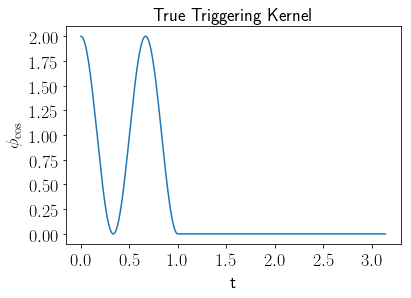

sequence size:  [109, 98, 54, 186, 140, 148, 85, 91, 133, 77]


In [20]:
def BS_simulation_stack(phi, mu, run_time):
    # simulate a Hawkes process using the represention of 
    # the Poisson cluster processes
    
    in_poi = SimuInhomogeneousPoisson([mu], end_time=run_time, verbose=False)
    in_poi.simulate()
    p = 0
    D = [(p, t) for t in in_poi.timestamps[0]]
    while True:
        c = D[p][1]
        p = p+1
        in_poi = SimuInhomogeneousPoisson([phi], end_time=run_time - c, verbose=False)
        in_poi.simulate()
        D += [(p, t + c) for t in in_poi.timestamps[0]]
        if p == len(D):
            break
    return D


# cosine triggering kernel
run_time = np.pi
ts1 = np.linspace(0, 1, 512)
f = lambda t: np.cos(3*np.pi*t)+1
ys1 = f(ts1)
tf_phi_cos = TimeFunction([ts1, ys1])

# visualize the triggering kernel
xplot = np.linspace(0,run_time,1024)
plt.plot(xplot, tf_phi_cos.value(xplot))
plt.xlabel('t',fontsize=18)
plt.ylabel('$\phi_{\cos}$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('True Triggering Kernel',fontsize=18)
plt.show()

# backgroun intensity: mu = 10
ts2 = np.linspace(0, run_time, 256)
ys2 = np.ones(len(ts2))*10
tf_mu = TimeFunction([ts2, ys2])

# sample 10 sequences
Ds = []
num_hist = 10
for _ in range(num_hist):
    D = BS_simulation_stack(tf_phi_cos, tf_mu, run_time)
    Ds += [D]
print('sequence size: ', [len(D) for D in Ds])

# Experiment - Infer the True Triggering Kernel

/home/rzhang/Documents/Efficient-Nonparametric-Bayesian-Hawkes-Processes/cov.py:81: RuntimeWarning: divide by zero encountered in true_divide
  integral[:, range(1, nterms), range(1, nterms)] = (ud2 + (0.25 / m * np.sin(2.0 * m * u)))[:, 0, 1:]
/home/rzhang/Documents/Efficient-Nonparametric-Bayesian-Hawkes-Processes/cov.py:81: RuntimeWarning: invalid value encountered in multiply
  integral[:, range(1, nterms), range(1, nterms)] = (ud2 + (0.25 / m * np.sin(2.0 * m * u)))[:, 0, 1:]
/home/rzhang/Documents/Efficient-Nonparametric-Bayesian-Hawkes-Processes/cov.py:81: RuntimeWarning: divide by zero encountered in true_divide
  integral[:, range(1, nterms), range(1, nterms)] = (ud2 + (0.25 / m * np.sin(2.0 * m * u)))[:, 0, 1:]
/home/rzhang/Documents/Efficient-Nonparametric-Bayesian-Hawkes-Processes/cov.py:81: RuntimeWarning: invalid value encountered in multiply
  integral[:, range(1, nterms), range(1, nterms)] = (ud2 + (0.25 / m * np.sin(2.0 * m * u)))[:, 0, 1:]


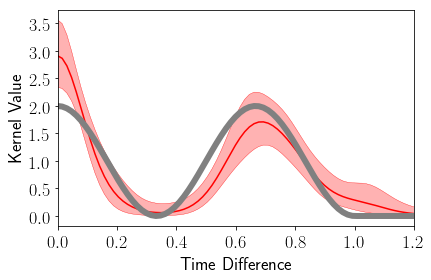

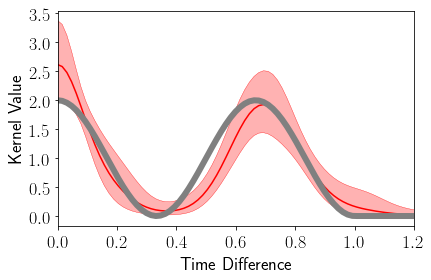

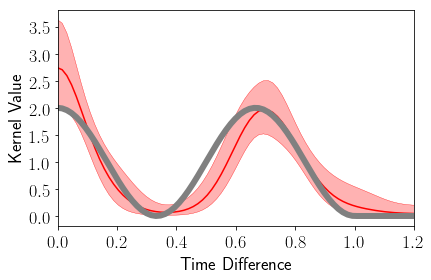

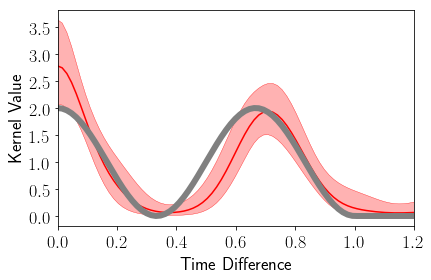

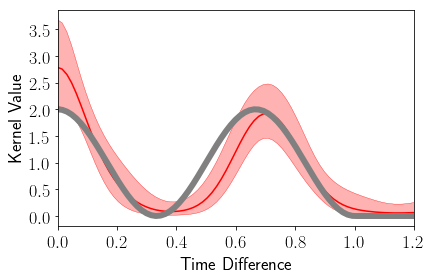

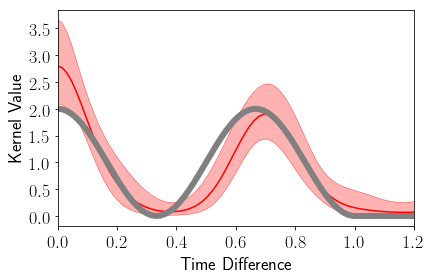

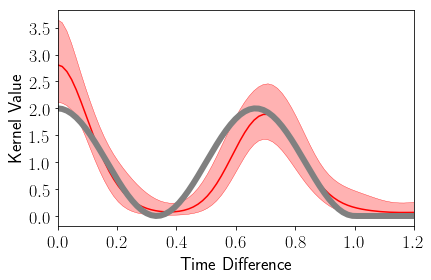

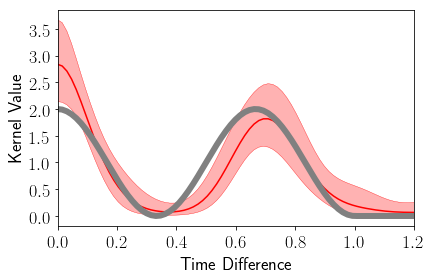

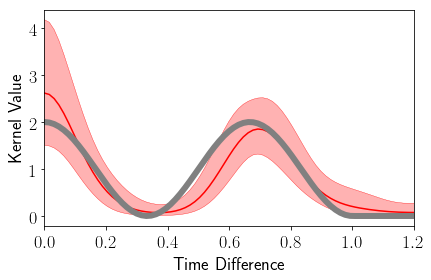

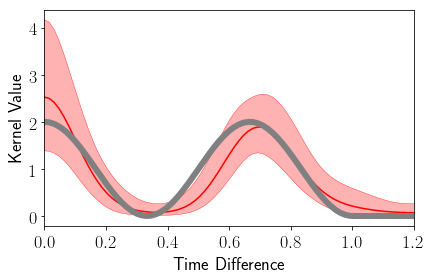

In [22]:
# GP kernel
ab = 0.002
covfn = cov.GGCPCov(name='cosine', a=ab, b=ab, nterms=32, m=2, d=1)
Omega = np.diag(1 / covfn.lambdas)

# plotted x
xs = np.linspace(0., 2, 128).reshape((1, -1))
phixstar = covfn._phi(xs)

# plot configuration
def plt_config(tf_phi):
    plt.plot(xs.flatten(), [tf_phi.value(x) for x in xs.flatten()], 'gray', lw=6, label="True kernel")
    plt.xlabel('Time Difference', fontsize=18)
    plt.ylabel('Kernel Value', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

#　sensors recording samples
rm_f = ElementWiseRunningStatistic(RunningMean)
rstd_f = ElementWiseRunningStatistic(RunningSTD)
rm_mu = ElementWiseRunningStatistic(RunningMean)
rstd_mu = ElementWiseRunningStatistic(RunningSTD)
phi_f = lambda x:np.exp(-0.8*x)
mu_constant = 50

# pre-processing data
hp_data_list = []
for i in range(num_hist):
    hp_data = np.array(sorted([d[1] for d in Ds[i]]))
    hp_data_list += [hp_data]
hp_data_list = [np.array([hist]) for hist in hp_data_list]
hist_cluster0 = [[[], hp_data[0,-1]] for hp_data in hp_data_list]

# gibbs ierations
e1, e2 = 1+1/run_time, 1/(run_time+1)
for ite in range(2001):
    K = 0
    hist_cluster = hist_cluster0.copy()
    
    # sampling branching structures and decomposing HP's to clusters of PP's
    for hp_data in hp_data_list:
        Sij = sij(hp_data, phi_f, mu_constant)
        hist_cluster += [[(hp_data[0,i+1:])[Sij[i+1:]==i+1]-hp_data[0,i],hp_data[0,i]] \
                    if any(Sij[i+1:]==i+1)>0 else [[], hp_data[0,i]] for i in range(hp_data.shape[1]-1)]
        K += sum(Sij == 0)
    
    # triggering kernel
    w, Q, _ = laplace_map_w(covfn, hist_cluster, Omega)
    mu_f, sigma_f, Sigma_f = laplace_pred_w(phixstar, w, Q)
    samples = np.random.multivariate_normal(mu_f, Sigma_f, 1)

    # background intensity
    K /= num_hist
    mu_constant = np.random.gamma(K*e1, e2)
    
    # recording samples
    if ite >= 1000:
        rm_f.observe(samples)
        rstd_f.observe(samples)
    tmp_mu_array = np.array([[mu_constant]])
    rm_mu.observe(tmp_mu_array)
    rstd_mu.observe(tmp_mu_array)
    
    # updating the triggering kernel
    samples = 0.5*samples**2
    phi_f = lambda x: np.interp(x, xs[0], samples[0])

    # ploting the estimated posterior distribution
    if ite > 1000 and ite % 100 == 0:
        plt.figure(figsize = (6,4))
        quantiles = squared_normal_quantiles(rm_f.aggregate().flatten(), rstd_f.aggregate().flatten(), [0.1, 0.5, 0.9])
        wp.gpplot(xs[0], quantiles[:, 1], quantiles[:, 0], quantiles[:, 2], fillcol='r', edgecol='r',mulabel='Gibbs_Hawkes')
        plt_config(tf_phi_cos)
        plt.tight_layout()
        plt.xlim(0,1.2)
        plt.plot()